In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from numpy.linalg import inv, eig
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
try:
    import statsmodels.api.add_constant
except ImportError:
    pass

In [2]:
ozone = pd.read_csv('ozone.csv')

In [3]:
n = ozone.shape[0]

#Loading data
X = ozone.drop(columns=['ozone']).to_numpy()
Y = ozone['ozone'].to_numpy()

# Center data
Y_centered = Y - np.mean(Y)
X_centered = X - np.mean(X, axis=0)

# Standardize X (centered and scaled)
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = scaler.fit_transform(X)

#Feature names
colnames = ozone.columns[1:9]
colnames

Index(['temp', 'invHt', 'press', 'vis', 'milPress', 'hum', 'invTemp', 'wind'], dtype='object')

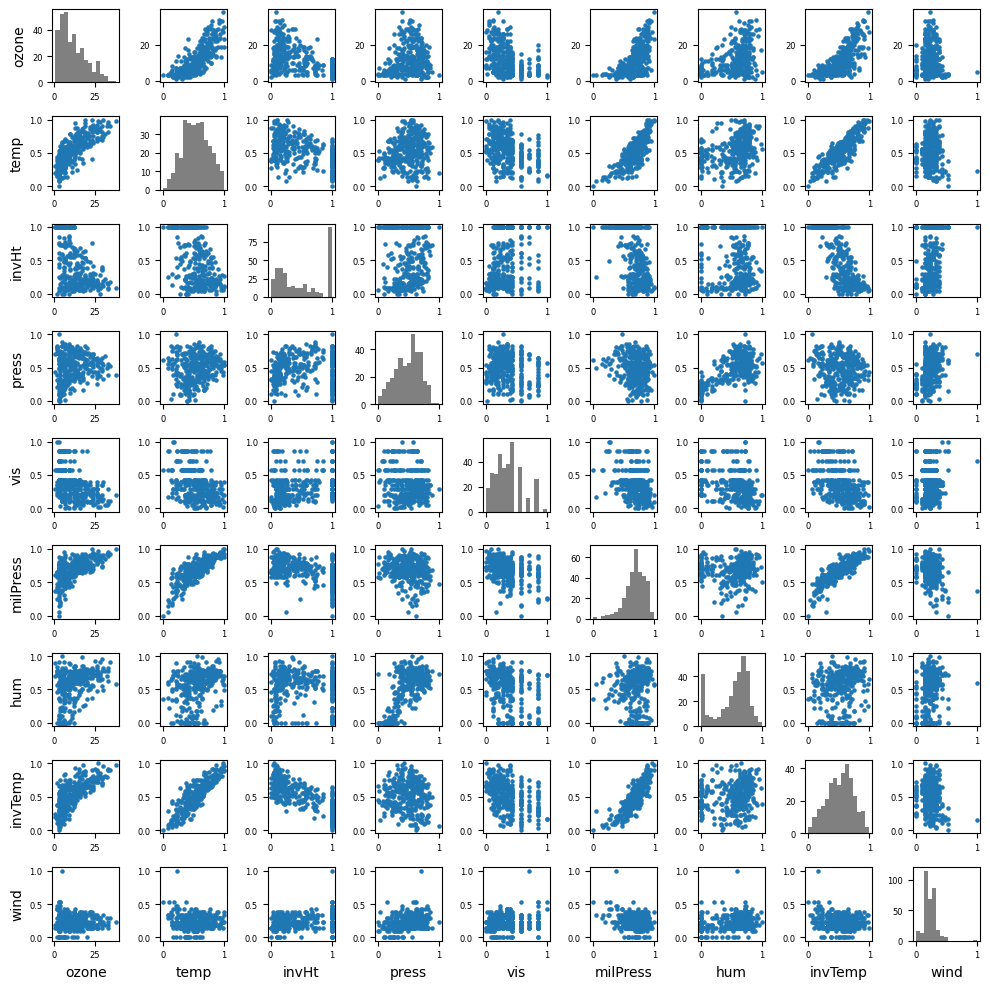

In [5]:
# Number of variables
variables = ozone.columns
num_vars = len(variables)

# Create a figure and axis grid
fig, axes = plt.subplots(num_vars, num_vars, figsize=(10, 10))

# Generate plots
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        ax = axes[i, j]
        if i != j:
            ax.scatter(ozone[var2], ozone[var1], s=5)
        else:
            # For diagonal, display histogram
            ax.hist(ozone[var1], bins=15, color='gray')
        if i == num_vars - 1:
            ax.set_xlabel(var2)
        if j == 0:
            ax.set_ylabel(var1)
        ax.tick_params(axis='both', which='both', labelsize=6)

# Adjust layout
plt.tight_layout()
plt.show()

## Ridge regression

#### Ridge Regresson by hand

In [4]:
lam1 = n * 1
lam2 = n * 10

betals = np.linalg.inv(X_standardized.T @ X_standardized) @ (X_standardized.T @ Y_centered)
betar1 = np.linalg.inv(X_standardized.T @ X_standardized + np.diag([lam1] * X_standardized.shape[1])) @ (X_standardized.T @ Y_centered)
betar2 = np.linalg.inv(X_standardized.T @ X_standardized + np.diag([lam2] * X_standardized.shape[1])) @ (X_standardized.T @ Y_centered)

print("Coefficients comparison:")
print(pd.DataFrame(np.column_stack((colnames,betals, betar1, betar2)), columns=["Feature","LS", "Lam=1", "Lam=10"]))

Coefficients comparison:
    Feature        LS     Lam=1    Lam=10
0      temp  3.954079  1.605254  0.470994
1     invHt -0.957115 -0.980377 -0.344422
2     press  0.056038  0.480175  0.137834
3       vis -0.518378 -0.615595 -0.252078
4  milPress -0.724833  0.868272   0.34903
5       hum  1.395777  0.938469  0.276554
6   invTemp  1.948347  1.349336  0.440295
7      wind  0.154378  0.166292  0.006884


**Ridge regression using sklearn.linear_model.Ridge**

In [5]:
ridge = Ridge(alpha=lam1, fit_intercept=False)
ridge.fit(X_standardized, Y_centered)
beta3 = ridge.coef_

res = np.column_stack((colnames,betals, betar1, betar2, beta3))
res_columns = ["Feature","LS", "Lam=1", "Lam=10", "Ridge Lam=1"]
print(pd.DataFrame(res, columns=res_columns))

    Feature        LS     Lam=1    Lam=10 Ridge Lam=1
0      temp  3.954079  1.605254  0.470994    1.605254
1     invHt -0.957115 -0.980377 -0.344422   -0.980377
2     press  0.056038  0.480175  0.137834    0.480175
3       vis -0.518378 -0.615595 -0.252078   -0.615595
4  milPress -0.724833  0.868272   0.34903    0.868272
5       hum  1.395777  0.938469  0.276554    0.938469
6   invTemp  1.948347  1.349336  0.440295    1.349336
7      wind  0.154378  0.166292  0.006884    0.166292


**What if we don't standardize X?**

In [6]:
betar_s = np.linalg.solve(
    X_standardized.T @ X_standardized + lam1 * np.eye(X_standardized.shape[1]),
    X_standardized.T @ Y_centered,
)
betar_ns = np.linalg.solve(
    X_centered.T @ X_centered + lam2 * np.eye(X_centered.shape[1]),
    X_centered.T @ Y_centered,
)

res_no_scale = np.column_stack((colnames,betar_s, betar_ns))
res_no_scale_columns = ["Feature","X Standardized", "X Not Scaled"]
print(pd.DataFrame(res_no_scale, columns=res_no_scale_columns))

    Feature X Standardized X Not Scaled
0      temp       1.605254     0.130212
1     invHt      -0.980377    -0.169404
2     press       0.480175      0.03421
3       vis      -0.615595     -0.07806
4  milPress       0.868272     0.079762
5       hum       0.938469     0.094497
6   invTemp       1.349336     0.125275
7      wind       0.166292    -0.000985


**Ridge Regression Regularization Paths**

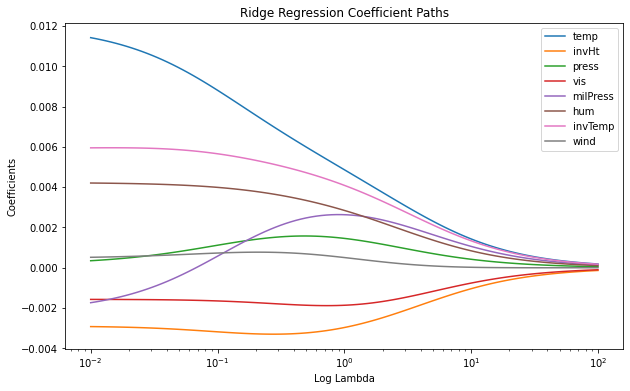

In [7]:
lambdas = np.exp(np.linspace(np.log(0.01), np.log(100), 100))
betasr = np.zeros((len(lambdas), X.shape[1]))
for i, lamb in enumerate(lambdas):
    betasr[i, :] = np.linalg.inv(X_standardized.T @ X_standardized + np.diag([n*lamb] * X_standardized.shape[1])) @ (X_standardized.T @ Y_centered / n)

# Plot Ridge paths
plt.figure(figsize=(10, 6))
for j in range(X_standardized.shape[1]):
    plt.plot(lambdas, betasr[:, j], label=f"Variable {j+1}")
plt.xscale("log")
plt.xlabel("Log Lambda")
plt.ylabel("Coefficients")
plt.title("Ridge Regression Coefficient Paths")
plt.legend(colnames)
plt.show()